In [108]:
%load_ext autoreload
%autoreload 2

import pythainlp, transformers
pythainlp.__version__, transformers.__version__ #fix pythainlp to stabilize word tokenization for metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('2.2.4', '4.4.0')

In [139]:
import collections
import logging
import pprint
import re
from tqdm.auto import tqdm
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 800)

import torch

#datasets
from datasets import (
    load_dataset, 
    load_metric, 
    load_from_disk,
)

#transformers
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    default_data_collator,
)

#thai2transformers
import thai2transformers
from thai2transformers.metrics import (
    squad_newmm_metric,
    question_answering_metrics,
    _postprocess_qa_predictions
)
from thai2transformers.preprocess import (
    prepare_qa_train_features,
    prepare_qa_validation_features,
)

#parameterizing columns
CONTEXT_COL = 'context'
QUESTION_COL = 'question'
ANSWERS_COL = 'answers'
TEXT_COL = 'text'
START_COL = 'answer_start'
END_COL = 'answer_end'
QUESTION_ID_COL = 'question_id'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # Remove the CWD from sys.path while we load stuff.


## Datasets

In [12]:
datasets_cased = load_from_disk('iapp_thaiqa')

#lowercase when using uncased model
def lowercase_example(example):
    example[QUESTION_COL] =  example[QUESTION_COL].lower()
    example[CONTEXT_COL] =  example[CONTEXT_COL].lower()
    example[ANSWERS_COL][TEXT_COL] =  [example[ANSWERS_COL][TEXT_COL][0].lower()]
    return example

datasets_uncased = datasets_cased.map(lowercase_example)

Loading cached processed dataset at iapp_thaiqa/train/cache-ffa098ec2666f141.arrow
Loading cached processed dataset at iapp_thaiqa/validation/cache-8c23515661e2ced7.arrow
Loading cached processed dataset at iapp_thaiqa/test/cache-1466b900c9be98ee.arrow


## Models

In [10]:
#wangchan
tokenizer_wangchan = AutoTokenizer.from_pretrained("cstorm125/wangchanberta-base-att-spm-uncased-finetune-qa")
model_wangchan = AutoModelForQuestionAnswering.from_pretrained("cstorm125/wangchanberta-base-att-spm-uncased-finetune-qa")

#mbert
tokenizer_mbert = AutoTokenizer.from_pretrained("cstorm125/bert-base-multilingual-cased-finetune-qa")
model_mbert = AutoModelForQuestionAnswering.from_pretrained("cstorm125/bert-base-multilingual-cased-finetune-qa")

#xlm
tokenizer_xlm = AutoTokenizer.from_pretrained("cstorm125/xlm-roberta-base-finetune-qa")
model_xlm = AutoModelForQuestionAnswering.from_pretrained("cstorm125/xlm-roberta-base-finetune-qa")

## Compare Final Results

In [39]:
def compare_final_results(tokenizer, 
                          model, 
                          datasets, 
                          n_best_size=20,
                          max_answer_length=100,
                          allow_no_answer=False,
                          max_length=416,):
    
    test_features = datasets.map(
        lambda x: prepare_qa_validation_features(x, tokenizer),
        batched=True,
        remove_columns=datasets.column_names
    )
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
    )
    metrics, formatted_predictions, references = question_answering_metrics(datasets = datasets,
                                                                            trainer=trainer,
                                                                            metric=squad_newmm_metric,
                                                                            n_best_size=n_best_size,
                                                                            max_answer_length=max_answer_length,
                                                                            allow_no_answer=allow_no_answer,
                                                                            question_col='question',
                                                                            context_col='context',
                                                                            question_id_col='question_id',
                                                                            answers_col='answers',
                                                                            text_col='text',
                                                                            start_col='answer_start',
                                                                            pad_on_right=True,
                                                                            max_length=max_length,
                                                                            doc_stride=128)

    pred = pd.DataFrame(formatted_predictions)
    ref = pd.DataFrame(references)
    ref['answer_text'] = ref.answers.map(lambda x: x['text'][0])
    question_df = pd.DataFrame(datasets)[['question_id','context','question']]
    question_df.columns = ['id','context','question']

    compare = ref[['id','answer_text']].merge(pred).merge(question_df)
    compare['exact_match'] = compare.answer_text==compare.prediction_text
    compare['f1'] = [squad_newmm_metric.compute(predictions=[p],references=[r])['f1'] for p,r in zip(formatted_predictions, references)]
    compare['partial_ratio'] = compare.apply(lambda row: fuzz.partial_ratio(str(row['answer_text']),
                                                                            str(row['prediction_text'])),1)

    # compare.sort_values('f1')[['question','answer_text','prediction_text','f1']]
    return compare, metrics

In [44]:
df_wangchan, metrics_wangchan = compare_final_results(tokenizer_wangchan, 
                                      model_wangchan, 
                                      datasets_uncased['validation'], 
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=416,)

df_xlm, metrics_xlm = compare_final_results(tokenizer_xlm, 
                                      model_xlm, 
                                      datasets_uncased['validation'], 
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

df_mbert, metrics_mbert = compare_final_results(tokenizer_mbert, 
                                      model_mbert, 
                                      datasets_uncased['validation'], 
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

Loading cached processed dataset at iapp_thaiqa/validation/cache-014b7f47892c0aea.arrow


Loading cached processed dataset at iapp_thaiqa/validation/cache-2fccd3a481536918.arrow


Loading cached processed dataset at iapp_thaiqa/validation/cache-3ab0ba0cc178ca11.arrow


### Metrics

The gap most likely comes from the 7% difference in exact matches.

In [45]:
#final metrics; our exact match has a problem
metrics_wangchan, metrics_xlm, metrics_mbert

({'exact_match': 45.14824797843666, 'f1': 73.01462087634768},
 {'exact_match': 52.83018867924528, 'f1': 77.6168193819229},
 {'exact_match': 52.695417789757414, 'f1': 75.57343632000989})

### Deep Dive `wangchanberta` vs `xlmr`

In [125]:
a = df_wangchan[['id','question','answer_text','prediction_text','f1','partial_ratio']]
a.columns = ['id','question','answer_text','prediction_text_wangchan','f1_wangchan','partial_ratio_wangchan']
b = df_xlm[['id','question','answer_text','prediction_text','f1','partial_ratio']]
b.columns = ['id','question','answer_text','prediction_text_xlm','f1_xlm','partial_ratio_xlm']

ab = a.merge(b, on=['id','question','answer_text'])
ab.head()

,id,question,answer_text,prediction_text_wangchan,f1_wangchan,partial_ratio_wangchan,prediction_text_xlm,f1_xlm,partial_ratio_xlm
0,0U2lA8nJQESIxbZrjZQc_000,สุวัฒน์ วรรณศิริกุล เกิดวันที่เท่าไร,1 พฤศจิกายน พ.ศ. 2476,1 พฤศจิกายน พ.ศ. 2476,100.0,100,(1 พฤศจิกายน พ.ศ. 2476,93.333333,100
1,0U2lA8nJQESIxbZrjZQc_001,สุวัฒน์ วรรณศิริกุล เสียชีวิตช่วงไหน,31 กรกฎาคม พ.ศ. 2555,31 กรกฎาคม พ.ศ. 2555,100.0,100,31 กรกฎาคม พ.ศ. 2555,100.000000,100
2,0U2lA8nJQESIxbZrjZQc_003,สุวัฒน์ วรรณศิริกุล ได้รับการเลือกตั้งเป็นสมาชิกสภาผู้แทนราษฎรครั้งแรกในปีอะไร,พ.ศ. 2529,พ.ศ. 2529,100.0,100,พ.ศ. 2529,100.000000,100
3,1bTjyZ6RFqHEk9Xx5HdW_000,แผ่นดินไหวในรัฐเชียปัส เกิดขึ้นปีอะไร,พ.ศ. 2560,พ.ศ. 2560,100.0,100,พ.ศ. 2560,100.000000,100
4,1bTjyZ6RFqHEk9Xx5HdW_001,แผ่นดินไหวในรัฐเชียปัส เกิดขึ้นปีอะไร,7 กันยายน พ.ศ. 2560,พ.ศ. 2560,60.0,100,พ.ศ. 2560,60.000000,100


#### Distribution of F1

Confirms our hypothesis that difference lies in exact matches. Furthermore, those mistakes mostly come from totally wrong answers (`f1`=0) and mostly wrong answers (`f1`<50).

* yellow = `wangchan`
* blue = `xlmr`

<AxesSubplot:>

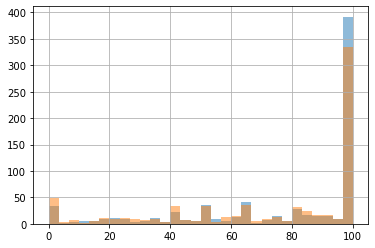

In [126]:
ab.f1_xlm.hist(bins=30, alpha=0.5)
ab.f1_wangchan.hist(bins=30, alpha=0.5)

<AxesSubplot:>

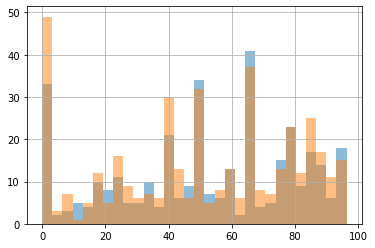

In [127]:
#plot only non-exact matches
ab[ab.f1_xlm<100].f1_xlm.hist(bins=30, alpha=0.5)
ab[ab.f1_wangchan<100].f1_wangchan.hist(bins=30, alpha=0.5)

In [128]:
#difference in exact matches
(ab.f1_xlm==100).sum() - (ab.f1_wangchan==100).sum(), ((ab.f1_xlm==100).sum() - (ab.f1_wangchan==100).sum()) / ab.shape[0]

(57, 0.07681940700808626)

In [129]:
#difference in f1 = 0
(ab.f1_wangchan==0).sum() - (ab.f1_xlm==0).sum(), ((ab.f1_wangchan==0).sum() - (ab.f1_xlm==0).sum()) / ab.shape[0]

(16, 0.0215633423180593)

In [130]:
#difference in f1 < 50
(ab.f1_wangchan<50).sum() - (ab.f1_xlm<50).sum(), ((ab.f1_wangchan<50).sum() - (ab.f1_xlm<50).sum()) / ab.shape[0]

(39, 0.05256064690026954)

#### Token-level F1 vs Fuzziness

Similar patterns suggest we might have same relative performance despite token-level (word, syllable, character) but we will try anyways.

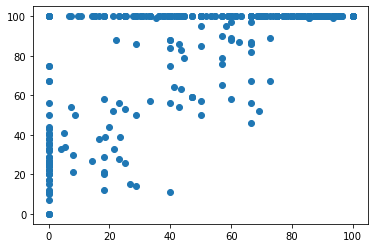

In [140]:
plt.scatter(df_wangchan.f1, df_wangchan.partial_ratio)

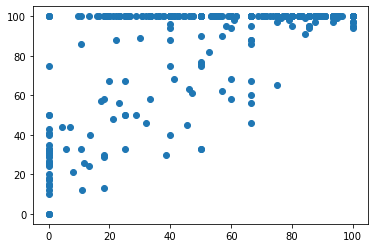

In [141]:
plt.scatter(df_xlm.f1, df_xlm.partial_ratio)

#### Contexts with sub-50 F1

In [131]:
wangchan_low =  df_wangchan[df_wangchan.f1<50].context.map(lambda x: x[:50]).value_counts().reset_index()
wangchan_low = wangchan_low[wangchan_low.context>1].reset_index(drop=True)
wangchan_low

,index,context
0,"""กระจกพ่นทราย"" วัสดุตกแต่งที่ให้ความรู้สึกเรียบหรู",5
1,นิวไคลด์กัมมันตรังสี (อังกฤษ: radionuclide) คืออะต,4
2,การยกกำลัง คือการดำเนินการทางคณิตศาสตร์อย่างหนึ่ง,4
3,เจ้าชายแอรดรูว์แห่งยูโกสลาเวีย (อังกฤษ: prince and,3
4,ภาพยนตร์การ์ตูนโทรทัศน์เรื่อง กินทามะ ภาค 4 กำกับโ,3
5,การโจมตีเพิร์ลฮาร์เบอร์ เป็นการโจมตีทางทหารอย่างน่,3
6,ประวัติ\nดร.อำนวย วีรวรรณ เกิดเมื่อวันที่ 1 กรกฎาคม,3
7,เนื่องด้วย สมาพันธ์สมาคมวิชาชีพวิทยุกระจายเสียงและ,3
8,"ศิลปา เศฏฏี (อังกฤษ: shilpa shetty, ฮินดี: शिल्पा",3
9,ทฤษฎีสัมพัทธภาพ (relativity theory)\n\nทฤษฎีสัมพัทธภ,3


In [132]:
xlm_low =  df_xlm[df_xlm.f1<50].context.map(lambda x: x[:50]).value_counts().reset_index()
xlm_low = xlm_low[xlm_low.context>1].reset_index(drop=True)
xlm_low

,index,context
0,การยกกำลัง คือการดำเนินการทางคณิตศาสตร์อย่างหนึ่ง,4
1,นิวไคลด์กัมมันตรังสี (อังกฤษ: radionuclide) คืออะต,4
2,"ศิลปา เศฏฏี (อังกฤษ: shilpa shetty, ฮินดี: शिल्पा",3
3,ดิสคัฟเวอรีไซแอ็นซ์เอเชีย (อังกฤษ: discovery scien,3
4,แม่น้ำโทเนะ (ญี่ปุ่น: 利根川 tone-gawa) ในแม่น้ำในภูม,3
5,เนื่องด้วย สมาพันธ์สมาคมวิชาชีพวิทยุกระจายเสียงและ,3
6,"""กระจกพ่นทราย"" วัสดุตกแต่งที่ให้ความรู้สึกเรียบหรู",3
7,เชฟโรเลต แคปติวา อังกฤษ: chevrolet captiva มีชื่อเ,3
8,เดอะลอร์ดออฟเดอะริงส์ (อังกฤษ: the lord of the rin,3
9,พระเจ้าอันจังแห่งโคกูรยอ (เกาหลี: 안장왕; อังกฤษ: anj,3


We can confirm this is not because of translation since `wangchanberta` also underperforms in Thai-only contexts.

In [133]:
#top wangchan misses vs xlm gets it
wx = wangchan_low.merge(xlm_low, how='left', on='index')
wx[wx.context_y.isna()]

,index,context_x,context_y
4,ภาพยนตร์การ์ตูนโทรทัศน์เรื่อง กินทามะ ภาค 4 กำกับโ,3,NaN
6,ประวัติ\nดร.อำนวย วีรวรรณ เกิดเมื่อวันที่ 1 กรกฎาคม,3,NaN
10,อุทยานแห่งชาติหมู่เกาะช้าง อุทยานแห่งชาติหมู่เกาะช,3,NaN
12,การเรียกซ้ำ (อังกฤษ: recursion) หรือ การเวียนเกิด,3,NaN
14,คลาวด์ สไตรฟ์ (ญี่ปุ่น: クラウド・ストライフ; อังกฤษ: cloud,2,NaN
17,พระราชพิธีอาพาธพินาศ เป็นพระราชพิธีที่เกิดขึ้นในต้,2,NaN
19,เบิร์ดแมน มายาดาว (อังกฤษ: birdman or (the unexpec,2,NaN
20,ร้านเจ๊ไฝเป็นร้านสืบทอดกิจการมาจากรุ่นพ่อ อายุได้,2,NaN
21,มหาวิทยาลัยเสรีแห่งเบอร์ลิน (fu berlin ; เยอรมัน:,2,NaN
22,"วงศ์ปลาแสงอาทิตย์ หรือ วงศ์ปลาโมลา (อังกฤษ: mola,",2,NaN


In [134]:
#top xlm misses vs wangchan gets it; significantly fewer
xw = xlm_low.merge(wangchan_low, how='left', on='index')
xw[xw.context_y.isna()]

,index,context_x,context_y
7,เชฟโรเลต แคปติวา อังกฤษ: chevrolet captiva มีชื่อเ,3,NaN
15,วันที่ 4 พฤษภาคม พ.ศ. 2561 เกิดแผ่นดินไหวขนาด 6.9,2,NaN
17,เลขอารบิก เป็นสัญลักษณ์ตัวเลขที่นิยมใช้กันมากที่สุ,2,NaN
22,เชฟโรเลต เบลแอร์ (อังกฤษ: chevrolet bel air) เป็นร,2,NaN
25,สามารถ ศรินทุ (ญี่ปุ่น: サーマート・シリントゥ; อังกฤษ: samar,2,NaN


### `xlmr` Exact Matches vs `wangchanberta` Non-Exact Matches

In [136]:
xlm_better_wangchan = ab[(ab.f1_xlm==100)&(ab.f1_wangchan<100)]
xlm_better_wangchan.sort_values('f1_wangchan')

,id,question,answer_text,prediction_text_wangchan,f1_wangchan,partial_ratio_wangchan,prediction_text_xlm,f1_xlm,partial_ratio_xlm
147,C9r3NZ2ChcJyqx9sYSR0_002,ต้นมะแว้งเครือมีชื่อเรียกทางพื้นเมืองว่าอะไร,แขว้งเคีย,วงศ์ : solanaceae,0.000000,10,แขว้งเคีย,100.0,100
331,SnDqcqqnjvqa6agwbZRQ_001,มาจูละห์ ซีงาปูรา เป็นคำภาษาอะไร,มลายู,ภาษามลายู,0.000000,100,มลายู,100.0,100
472,dwAUwMskIuFw0iVqG71q_014,สภาพป่าโดยทั่ว มีลักษณะอย่างไร,ป่าดิบเขา,สภาพป่าโดยทั่วไปมีอุดมสมบูรณ์,0.000000,44,ป่าดิบเขา,100.0,100
135,BwRJ2m7hsN6WmaWnkaEg_002,อำนวย วีรวรรณ สำเร็จการศึกษาปริญาตรีจากมหาลัยอะไร,จุฬาลงกรณ์มหาวิทยาลัย,โรงเรียนอัสสัมชัญ,0.000000,24,จุฬาลงกรณ์มหาวิทยาลัย,100.0,100
212,HwqDFBPfy66QCntkhzdW_001,แมโครมีเดีย ออเธอร์แวร์ คืออะไร,โปรแกรมที่มีพื้นฐานบนการใช้งานแบบผังงาน,อะโดบีซิสเต็มส์,0.000000,7,โปรแกรมที่มีพื้นฐานบนการใช้งานแบบผังงาน,100.0,100
220,Ig97KOqwWWNSjE1as4Iv_000,ieee 802.11b-1999 เป็นมาตรฐานการสื่อสารระดับที่เท่าไร,สอง,ระดับที่สอง,0.000000,100,สอง,100.0,100
372,VsVN58wWI3604UiEof6T_000,วิรดา นิราพาธพงศ์พร ชื่อเล่นคือ ?,อุ๋ย,ุ๋ย,0.000000,100,อุ๋ย,100.0,100
531,leAJVOH4RAcLUxsx96v6_004,พระราชพิธีอาพาธพินาศ เรียกอีกชื่อหนึ่งว่าอะไร,แร้งวัดสระเกศ,พระราชพิธีอาพาธพินาศ,0.000000,15,แร้งวัดสระเกศ,100.0,100
434,c1NV2pc2f3MKpB30qT00_008,ใครเป็นผู้ล้มล้างแนวคิดเรื่องอีเทอร์,ไอน์สไตน์,อีเทอร์และการอยู่นิ่งสัมบูรณ์,0.000000,22,ไอน์สไตน์,100.0,100
268,OiwbWtGzxPR4OIQKi12S_001,เจ้าชายแอรดรูว์แห่งยูโกสลาเวีย เกิดขึ้นที่ไหน,ราชอาณาจักรยูโกสลาเวีย,พระราชวังโคบอร์ก,0.000000,38,ราชอาณาจักรยูโกสลาเวีย,100.0,100


1. new metrics: character-level, syllable-level
3. try other pretrained such as XNLI, wiki spm